In [1]:
# Imports
import os
import torch
import numpy as np
import re
from importlib import reload

# Training/Test Set Creation - to use later
from sklearn.model_selection import StratifiedShuffleSplit

# Dataset Creation
from collections import Counter
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize

# Model Training and Definition
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import trainutils_leon

# Create Training and Test Sets

## Load real edited videos

In [2]:
# Specify directories
frame_folder = "./data/frames"

# Construct X = folder names, y = the label
vf_list = os.listdir(frame_folder)

X_paths = [] # paths of segment folders
y = [] # designated label

for vf_folder in vf_list:
    
    # Create path to video
    vf_path = os.path.join(frame_folder, vf_folder)
    print("Current Video: "+ vf_folder)
    
    # Get individual segment folder
    segfolder_list = os.listdir(vf_path)
    
    # Check every segment folder
    for seg_folder in segfolder_list:
        
        #print(seg_folder)
        x_path = os.path.join(vf_path, seg_folder)
        #print(x_path)
        X_paths.append(x_path)
        
        # Extract class label from folder name
        label = int(seg_folder.split("_")[2])
        #print(label)
        y.append(label) # x 100 + 100
    
# create pytorch dataset class
class SyncDataset(Dataset):
    
    def __init__(self, X, y, transform=None):
        self.transform = transform
        self.X = X
        self.y = y
    
    # Returns length
    def __len__(self):
        return len(self.X)
    
    # Returns X feature array and y value
    def __getitem__(self, idx):
        
        # Load npz file
        npz_path = self.X[idx]+'/features.npz'
        data = np.load(npz_path)
        X_feat = data['feature_array']
        
        # apply transform
        if self.transform:
            X_tensor = self.transform(X_feat).squeeze().float()
        else:
            # Convert X to tensor
            X_tensor = torch.from_numpy(X_feat).float()
        
        return X_tensor, self.y[idx] # y_tensor
        
# Display video count and classes
len(X_paths), len(y), Counter(y)

Current Video: video1
Current Video: video2
Current Video: video3
Current Video: video4


(504,
 504,
 Counter({1: 54,
          2: 49,
          4: 50,
          5: 51,
          8: 52,
          9: 52,
          0: 48,
          3: 50,
          6: 48,
          7: 50}))

# Create Pytorch Dataset

In [3]:
# Split into training and test sets
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.1, random_state = 0)
train_set, test_set = next(splitter.split(X_paths, y))

# Training Set
train_X_paths = [X_paths[i] for i in train_set]
train_ys = [y[i] for i in train_set]
print("Training Set: ({0},{1})".format(len(train_X_paths), len(train_ys)))

# Test Set
test_X_paths = [X_paths[i] for i in test_set]
test_ys = [y[i] for i in test_set]
print("Test Set: ({0},{1})".format(len(test_X_paths), len(test_ys)))

Training Set: (453,453)
Test Set: (51,51)


In [4]:
# Set seeds for reproducibility
np.random.seed(4139)
torch.manual_seed(4139)

In [5]:
# define normalization
class norm_per_keypt(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        sub1 = normalize(sample[:,0:56], axis=1)
        sub2 = normalize(sample[:,56:112], axis=1)
        sub3 = normalize(sample[:,112:168], axis=1)
        # recombine subjects
        scaled_sample = np.concatenate((sub1, sub2, sub3),axis=1)
        return scaled_sample
    
class norm_over_frames(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = normalize(sample, axis=1)
        return scaled_sample
    
class norm_over_all(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = normalize(sample)
        return scaled_sample
    
dataset = []
training_dataset = SyncDataset(X = train_X_paths, y = train_ys)
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys)
for train_X, train_y in training_dataset:
    new_row = train_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
# New: Test set
for test_X, test_y in testing_dataset:
    new_row = test_X.data.numpy()
    if len(dataset) == 0:
        dataset = new_row
    else:
        dataset = np.vstack((dataset,new_row))
saved_mean = np.mean(dataset, axis=0) 
saved_std = np.std(dataset, axis=0), 

class norm_with_saved(object):
    """
    Rescale so features are between 0 and 1 for each subject

    """
    def __call__(self, sample):
        # squeeze tensor
        sample = sample.squeeze()
        # normalize
        scaled_sample = (sample - saved_mean)/saved_std
        return scaled_sample

In [6]:
# Define Transformer - may need it for later, unused for now
transformer = transforms.Compose([
    norm_with_saved(),
    transforms.ToTensor(),
])

# Define Training Dataset 
training_dataset = SyncDataset(X = train_X_paths, y = train_ys, transform = transformer)

# Define Test Dataset
testing_dataset = SyncDataset(X = test_X_paths, y = test_ys, transform = transformer)

## Define Data Loader  
Data Loader for extracting batches from the Pytorch Dataset during model training

In [7]:
def batch_collater(batch):
    X_batch, y_batch = list(zip(*batch))
    
    # Separate batch into X and y
    X_batch = [x for x in X_batch if len(x) > 0]
    y_batch = [torch.tensor(y) for y, x in zip(y_batch, X_batch) if len(x) > 0]
    
    # Convert into tensors
    X_tensor = torch.stack(X_batch)
    y_tensor = torch.stack(y_batch).long()
    
    return X_tensor, y_tensor

In [8]:
# Specify batch size
batch_size = 30

training_loader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)
testing_loader = DataLoader(testing_dataset, batch_size = batch_size, shuffle=True, collate_fn=batch_collater)

# check shapes
for xb, yb in training_loader:
    print(xb.shape, yb.shape)
    break

for xb, yb in testing_loader:
    print(xb.shape, yb.shape)
    break

torch.Size([30, 20, 168]) torch.Size([30])
torch.Size([30, 20, 168]) torch.Size([30])


# Model Definition

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
class SyncRNN(nn.Module):
    
    def __init__(self, params_model):
        
        super(SyncRNN, self).__init__()
        
        # Import Model Parameters
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"] # dropout rate
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]
        self.device = params_model["device"]
        num_features = 168
        batchsize = 1
        
        # Define Model Structure
        self.dropout = nn.Dropout(dr_rate) # - do we need this?
        self.rnn = nn.LSTM(num_features, rnn_hidden_size, rnn_num_layers)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)
        self.h0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size).cuda() # Initial hidden state
        self.c0 = torch.zeros(rnn_num_layers, batchsize, rnn_hidden_size).cuda() # Initial cell state
        
    def forward(self, x):
        
        # batch count, frame count, feature size
        batch_count, frame_count, feature_size = x.shape
        frame_idx = 0
        
        # Reshape the frame
        shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
        
        # Feed the first frame into the rnn
        output, (hn, cn) = self.rnn(shaped_frame, (self.h0, self.c0))
        
        # Feed the rest of the frames 
        for frame_idx in range(1, frame_count):
            shaped_frame = x[:, frame_idx].view(batch_count, 1, feature_size)
            output, (hn, cn) = self.rnn(shaped_frame, (hn, cn))
        
        #output = self.dropout(output[:,-1])
        output = self.fc1(output)
        
        return output

# Model Training  

Define loss function and optimizer to train the model

Table of tested params:

|  S/N  |  data  |  dr  |  layers  |  hidden_size  |  epochs  |   lr   |    loss     |  train_acc  |  test_acc | 
|-------|--------|------|----------|---------------|----------|--------|-------------|-------------|-----------|
|   1   |  real  |   0  |    1     |      300      |    100   |  3e-3  |   CE: 2.28  |      13     |     13    |
|   2   |  syn   |   0  |    1     |      300      |    30    |  3e-3  |   CE: 2.6   |      10     |     10    |
|   3   |  syn   |   0  |    1     |      300      |    30    |  0.1   |   CE: 2.45  |      10     |     10    |
|   4   |  syn   |   0  |    1     |      100      |    30    |  0.1   |   CE: 2.39  |      10     |     10    |
|   5   |  syn   |   0  |    1     |      100      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   6   |  syn   |   0  |    1     |      300      |    200   |  0.1   |  MSE: 8.04  |      9.8    |     9.8   |
|   7   |  syn   |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 8.04  |      9.8    |     9.8   |
|   8   |  real  |   0  |    1     |      100      |    200   |  3e-3  |  MSE: 20.7  |      9.8    |     9.8   |
|   9   |  real  |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      7.8    |     7.8   |
|   10  |r_inorm |   0  |    1     |      100      |    200   |  3     |  MSE: 8.3   |      9.8    |     9.8   |
|   11  |r_fnorm |   0  |    1     |      100      |    70    |  0.1   |  MSE: 8.3   |      9.8    |     9.8   |
|   12  |r_snorm |   0  |    1     |      100      |    70    |  0.1   |   CE: 1.5   |      9.8    |     9.8   |

In [11]:
# RNN Model Parameter
model_params = {
    "num_classes": 10,
    "dr_rate": 0.0,
    "rnn_num_layers": 1,
    "rnn_hidden_size": 200,
    "device": device # use "cpu"
}
model = SyncRNN(model_params)
model = model.to(device)

In [12]:
# Test Model with dummy input
with torch.no_grad():
    x = torch.randn(1, 20, 168)
    y = model(x.to(device))
    print(y.shape) # should be [1,10]

torch.Size([1, 1, 10])


In [13]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(reduction="sum")
#loss_fn = nn.MSELoss(reduction="sum")

# Define Optimizer (Adam)
optimizer = optim.Adam(model.parameters(), lr = 0.2) #3e-5 # 3e-3

# Define LR Scheduler
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience = 5, verbose=1)
os.makedirs("./models", exist_ok=True)

# Define Training Parameters - tweak this
train_params = {
    "num_epochs": 400,
    "optimizer": optimizer,
    "loss_fn": loss_fn,
    "training_loader": training_loader,
    "testing_loader": testing_loader,
    "lr_scheduler": lr_scheduler,
    "weights_path": "./models/weights_leon_norm_100_2.pt",
}

In [14]:
trained_model, loss_hist, metric_hist = trainutils_leon.train_model(model, train_params)

Epoch 0/399, current_lr=0.2



Saved best model weights
Train Loss: 5.336172, Dev Loss: 6.147611, Accuracy: 9.80
----------
Epoch 1/399, current_lr=0.2



Train Loss: 5.759226, Dev Loss: 6.820071, Accuracy: 3.92
----------
Epoch 2/399, current_lr=0.2



Saved best model weights
Train Loss: 5.765523, Dev Loss: 5.050599, Accuracy: 11.76
----------
Epoch 3/399, current_lr=0.2



Train Loss: 5.841665, Dev Loss: 5.872668, Accuracy: 13.73
----------
Epoch 4/399, current_lr=0.2



Train Loss: 5.463791, Dev Loss: 5.129932, Accuracy: 13.73
----------
Epoch 5/399, current_lr=0.2



Train Loss: 5.099158, Dev Loss: 6.783509, Accuracy: 7.84
----------
Epoch 6/399, current_lr=0.2



Train Loss: 5.981896, Dev Loss: 6.838088, Accuracy: 7.84
----------
Epoch 7/399, current_lr=0.2



Train Loss: 5.544307, Dev Loss: 7.123123, Accuracy: 11.76
----------
Epoch 8/399, current_lr=0.2



Epoch     9: reducing learning rate of group 0 to 1.4000e-01.
Loading best model weights
Train Loss: 5.531518, Dev Loss: 6.143050, Accuracy: 15.69
----------
Epoch 9/399, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 5.340494, Dev Loss: 4.915654, Accuracy: 19.61
----------
Epoch 10/399, current_lr=0.13999999999999999



Train Loss: 4.860830, Dev Loss: 5.085201, Accuracy: 9.80
----------
Epoch 11/399, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 4.855792, Dev Loss: 4.852334, Accuracy: 7.84
----------
Epoch 12/399, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 4.212829, Dev Loss: 4.836417, Accuracy: 7.84
----------
Epoch 13/399, current_lr=0.13999999999999999



Train Loss: 4.139134, Dev Loss: 5.454939, Accuracy: 7.84
----------
Epoch 14/399, current_lr=0.13999999999999999



Train Loss: 4.091308, Dev Loss: 5.745614, Accuracy: 5.88
----------
Epoch 15/399, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 4.168138, Dev Loss: 4.648044, Accuracy: 11.76
----------
Epoch 16/399, current_lr=0.13999999999999999



Train Loss: 4.250660, Dev Loss: 5.688616, Accuracy: 13.73
----------
Epoch 17/399, current_lr=0.13999999999999999



Train Loss: 4.259866, Dev Loss: 4.871328, Accuracy: 13.73
----------
Epoch 18/399, current_lr=0.13999999999999999



Train Loss: 4.438297, Dev Loss: 5.640974, Accuracy: 7.84
----------
Epoch 19/399, current_lr=0.13999999999999999



Train Loss: 4.138439, Dev Loss: 5.312791, Accuracy: 13.73
----------
Epoch 20/399, current_lr=0.13999999999999999



Saved best model weights
Train Loss: 4.294239, Dev Loss: 4.136576, Accuracy: 11.76
----------
Epoch 21/399, current_lr=0.13999999999999999



Train Loss: 3.622774, Dev Loss: 5.170869, Accuracy: 5.88
----------
Epoch 22/399, current_lr=0.13999999999999999



Train Loss: 3.878916, Dev Loss: 5.710615, Accuracy: 7.84
----------
Epoch 23/399, current_lr=0.13999999999999999



Train Loss: 4.242147, Dev Loss: 4.765187, Accuracy: 21.57
----------
Epoch 24/399, current_lr=0.13999999999999999



Train Loss: 4.111291, Dev Loss: 5.324092, Accuracy: 5.88
----------
Epoch 25/399, current_lr=0.13999999999999999



Train Loss: 4.079808, Dev Loss: 5.235982, Accuracy: 7.84
----------
Epoch 26/399, current_lr=0.13999999999999999



Epoch    27: reducing learning rate of group 0 to 9.8000e-02.
Loading best model weights
Train Loss: 3.992918, Dev Loss: 5.204357, Accuracy: 11.76
----------
Epoch 27/399, current_lr=0.09799999999999999



Train Loss: 3.526983, Dev Loss: 4.872342, Accuracy: 9.80
----------
Epoch 28/399, current_lr=0.09799999999999999



Train Loss: 3.331051, Dev Loss: 4.644467, Accuracy: 9.80
----------
Epoch 29/399, current_lr=0.09799999999999999



Train Loss: 3.268383, Dev Loss: 4.493276, Accuracy: 13.73
----------
Epoch 30/399, current_lr=0.09799999999999999



Train Loss: 3.289170, Dev Loss: 4.525210, Accuracy: 9.80
----------
Epoch 31/399, current_lr=0.09799999999999999



Train Loss: 3.096855, Dev Loss: 4.410290, Accuracy: 15.69
----------
Epoch 32/399, current_lr=0.09799999999999999



Saved best model weights
Train Loss: 3.010022, Dev Loss: 3.914166, Accuracy: 5.88
----------
Epoch 33/399, current_lr=0.09799999999999999



Train Loss: 3.166366, Dev Loss: 4.558707, Accuracy: 7.84
----------
Epoch 34/399, current_lr=0.09799999999999999



Train Loss: 2.956579, Dev Loss: 4.113843, Accuracy: 7.84
----------
Epoch 35/399, current_lr=0.09799999999999999



Train Loss: 3.008144, Dev Loss: 4.302989, Accuracy: 9.80
----------
Epoch 36/399, current_lr=0.09799999999999999



Saved best model weights
Train Loss: 3.020983, Dev Loss: 3.791840, Accuracy: 11.76
----------
Epoch 37/399, current_lr=0.09799999999999999



Train Loss: 3.042111, Dev Loss: 4.677568, Accuracy: 11.76
----------
Epoch 38/399, current_lr=0.09799999999999999



Train Loss: 3.105050, Dev Loss: 4.064721, Accuracy: 5.88
----------
Epoch 39/399, current_lr=0.09799999999999999



Train Loss: 2.803461, Dev Loss: 4.071162, Accuracy: 1.96
----------
Epoch 40/399, current_lr=0.09799999999999999



Train Loss: 2.993246, Dev Loss: 4.508811, Accuracy: 13.73
----------
Epoch 41/399, current_lr=0.09799999999999999



Train Loss: 2.824366, Dev Loss: 4.805744, Accuracy: 3.92
----------
Epoch 42/399, current_lr=0.09799999999999999



Epoch    43: reducing learning rate of group 0 to 6.8600e-02.
Loading best model weights
Train Loss: 3.024584, Dev Loss: 4.166700, Accuracy: 7.84
----------
Epoch 43/399, current_lr=0.0686



Train Loss: 2.624198, Dev Loss: 3.974304, Accuracy: 17.65
----------
Epoch 44/399, current_lr=0.0686



Saved best model weights
Train Loss: 2.588643, Dev Loss: 3.588135, Accuracy: 9.80
----------
Epoch 45/399, current_lr=0.0686



Train Loss: 2.424097, Dev Loss: 4.156084, Accuracy: 11.76
----------
Epoch 46/399, current_lr=0.0686



Train Loss: 2.434611, Dev Loss: 4.234494, Accuracy: 11.76
----------
Epoch 47/399, current_lr=0.0686



Train Loss: 2.564435, Dev Loss: 3.941324, Accuracy: 5.88
----------
Epoch 48/399, current_lr=0.0686



Train Loss: 2.411583, Dev Loss: 3.969033, Accuracy: 9.80
----------
Epoch 49/399, current_lr=0.0686



Train Loss: 2.348022, Dev Loss: 3.889841, Accuracy: 11.76
----------
Epoch 50/399, current_lr=0.0686



Saved best model weights
Train Loss: 2.337321, Dev Loss: 3.526027, Accuracy: 11.76
----------
Epoch 51/399, current_lr=0.0686



Train Loss: 2.202762, Dev Loss: 3.581473, Accuracy: 13.73
----------
Epoch 52/399, current_lr=0.0686



Train Loss: 2.245485, Dev Loss: 3.892846, Accuracy: 11.76
----------
Epoch 53/399, current_lr=0.0686



Train Loss: 2.353347, Dev Loss: 4.217938, Accuracy: 17.65
----------
Epoch 54/399, current_lr=0.0686



Train Loss: 2.331741, Dev Loss: 3.856748, Accuracy: 9.80
----------
Epoch 55/399, current_lr=0.0686



Train Loss: 2.260345, Dev Loss: 3.602515, Accuracy: 11.76
----------
Epoch 56/399, current_lr=0.0686



Epoch    57: reducing learning rate of group 0 to 4.8020e-02.
Loading best model weights
Train Loss: 2.374160, Dev Loss: 3.601048, Accuracy: 9.80
----------
Epoch 57/399, current_lr=0.04801999999999999



Train Loss: 2.244902, Dev Loss: 3.779642, Accuracy: 13.73
----------
Epoch 58/399, current_lr=0.04801999999999999



Train Loss: 2.157791, Dev Loss: 3.648515, Accuracy: 5.88
----------
Epoch 59/399, current_lr=0.04801999999999999



Train Loss: 2.003994, Dev Loss: 3.684418, Accuracy: 11.76
----------
Epoch 60/399, current_lr=0.04801999999999999



Train Loss: 2.060207, Dev Loss: 3.688685, Accuracy: 9.80
----------
Epoch 61/399, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 2.097189, Dev Loss: 3.435111, Accuracy: 17.65
----------
Epoch 62/399, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 1.979197, Dev Loss: 3.425650, Accuracy: 5.88
----------
Epoch 63/399, current_lr=0.04801999999999999



Saved best model weights
Train Loss: 2.101477, Dev Loss: 3.166200, Accuracy: 15.69
----------
Epoch 64/399, current_lr=0.04801999999999999



Train Loss: 2.015488, Dev Loss: 3.319536, Accuracy: 7.84
----------
Epoch 65/399, current_lr=0.04801999999999999



Train Loss: 1.919585, Dev Loss: 3.425043, Accuracy: 5.88
----------
Epoch 66/399, current_lr=0.04801999999999999



Train Loss: 1.999345, Dev Loss: 3.403067, Accuracy: 19.61
----------
Epoch 67/399, current_lr=0.04801999999999999



Train Loss: 1.941996, Dev Loss: 3.316073, Accuracy: 13.73
----------
Epoch 68/399, current_lr=0.04801999999999999



Train Loss: 2.018053, Dev Loss: 3.434525, Accuracy: 19.61
----------
Epoch 69/399, current_lr=0.04801999999999999



Epoch    70: reducing learning rate of group 0 to 3.3614e-02.
Loading best model weights
Train Loss: 1.988176, Dev Loss: 3.903764, Accuracy: 13.73
----------
Epoch 70/399, current_lr=0.03361399999999999



Train Loss: 1.919697, Dev Loss: 3.220899, Accuracy: 15.69
----------
Epoch 71/399, current_lr=0.03361399999999999



Train Loss: 1.855613, Dev Loss: 3.624584, Accuracy: 17.65
----------
Epoch 72/399, current_lr=0.03361399999999999



Train Loss: 1.946242, Dev Loss: 3.723789, Accuracy: 5.88
----------
Epoch 73/399, current_lr=0.03361399999999999



Train Loss: 1.852355, Dev Loss: 3.320717, Accuracy: 17.65
----------
Epoch 74/399, current_lr=0.03361399999999999



Train Loss: 1.825521, Dev Loss: 3.388980, Accuracy: 15.69
----------
Epoch 75/399, current_lr=0.03361399999999999



Epoch    76: reducing learning rate of group 0 to 2.3530e-02.
Loading best model weights
Train Loss: 1.824204, Dev Loss: 3.254199, Accuracy: 11.76
----------
Epoch 76/399, current_lr=0.023529799999999993



Train Loss: 1.914630, Dev Loss: 3.220187, Accuracy: 11.76
----------
Epoch 77/399, current_lr=0.023529799999999993



Train Loss: 1.796665, Dev Loss: 3.386602, Accuracy: 3.92
----------
Epoch 78/399, current_lr=0.023529799999999993



Train Loss: 1.780600, Dev Loss: 3.238211, Accuracy: 11.76
----------
Epoch 79/399, current_lr=0.023529799999999993



Train Loss: 1.716144, Dev Loss: 3.671326, Accuracy: 3.92
----------
Epoch 80/399, current_lr=0.023529799999999993



Train Loss: 1.757673, Dev Loss: 3.185311, Accuracy: 13.73
----------
Epoch 81/399, current_lr=0.023529799999999993



Saved best model weights
Train Loss: 1.670907, Dev Loss: 3.158656, Accuracy: 15.69
----------
Epoch 82/399, current_lr=0.023529799999999993



Train Loss: 1.673587, Dev Loss: 3.432667, Accuracy: 3.92
----------
Epoch 83/399, current_lr=0.023529799999999993



Train Loss: 1.725324, Dev Loss: 3.578190, Accuracy: 11.76
----------
Epoch 84/399, current_lr=0.023529799999999993



Train Loss: 1.681605, Dev Loss: 3.532987, Accuracy: 5.88
----------
Epoch 85/399, current_lr=0.023529799999999993



Train Loss: 1.652188, Dev Loss: 3.164894, Accuracy: 7.84
----------
Epoch 86/399, current_lr=0.023529799999999993



Saved best model weights
Train Loss: 1.666011, Dev Loss: 3.092819, Accuracy: 19.61
----------
Epoch 87/399, current_lr=0.023529799999999993



Train Loss: 1.698602, Dev Loss: 3.348653, Accuracy: 9.80
----------
Epoch 88/399, current_lr=0.023529799999999993



Train Loss: 1.651240, Dev Loss: 3.170555, Accuracy: 7.84
----------
Epoch 89/399, current_lr=0.023529799999999993



Saved best model weights
Train Loss: 1.615234, Dev Loss: 3.012268, Accuracy: 7.84
----------
Epoch 90/399, current_lr=0.023529799999999993



Train Loss: 1.631818, Dev Loss: 3.308368, Accuracy: 21.57
----------
Epoch 91/399, current_lr=0.023529799999999993



Train Loss: 1.586878, Dev Loss: 3.289064, Accuracy: 7.84
----------
Epoch 92/399, current_lr=0.023529799999999993



Train Loss: 1.568423, Dev Loss: 3.461247, Accuracy: 9.80
----------
Epoch 93/399, current_lr=0.023529799999999993



Train Loss: 1.621492, Dev Loss: 3.504249, Accuracy: 5.88
----------
Epoch 94/399, current_lr=0.023529799999999993



Train Loss: 1.598582, Dev Loss: 3.144497, Accuracy: 19.61
----------
Epoch 95/399, current_lr=0.023529799999999993



Epoch    96: reducing learning rate of group 0 to 1.6471e-02.
Loading best model weights
Train Loss: 1.628332, Dev Loss: 3.317956, Accuracy: 13.73
----------
Epoch 96/399, current_lr=0.016470859999999993



Train Loss: 1.575859, Dev Loss: 3.138014, Accuracy: 13.73
----------
Epoch 97/399, current_lr=0.016470859999999993



Train Loss: 1.576205, Dev Loss: 3.086507, Accuracy: 19.61
----------
Epoch 98/399, current_lr=0.016470859999999993



Train Loss: 1.515117, Dev Loss: 3.164877, Accuracy: 13.73
----------
Epoch 99/399, current_lr=0.016470859999999993



Train Loss: 1.615216, Dev Loss: 3.186506, Accuracy: 13.73
----------
Epoch 100/399, current_lr=0.016470859999999993



Train Loss: 1.594329, Dev Loss: 3.463427, Accuracy: 9.80
----------
Epoch 101/399, current_lr=0.016470859999999993



Epoch   102: reducing learning rate of group 0 to 1.1530e-02.
Loading best model weights
Train Loss: 1.578595, Dev Loss: 3.200089, Accuracy: 13.73
----------
Epoch 102/399, current_lr=0.011529601999999995



Train Loss: 1.576486, Dev Loss: 3.206707, Accuracy: 7.84
----------
Epoch 103/399, current_lr=0.011529601999999995



Train Loss: 1.519564, Dev Loss: 3.205998, Accuracy: 11.76
----------
Epoch 104/399, current_lr=0.011529601999999995



Saved best model weights
Train Loss: 1.515579, Dev Loss: 2.945679, Accuracy: 15.69
----------
Epoch 105/399, current_lr=0.011529601999999995



Train Loss: 1.587678, Dev Loss: 3.330824, Accuracy: 13.73
----------
Epoch 106/399, current_lr=0.011529601999999995



Train Loss: 1.560129, Dev Loss: 3.274487, Accuracy: 13.73
----------
Epoch 107/399, current_lr=0.011529601999999995



Saved best model weights
Train Loss: 1.531609, Dev Loss: 2.922423, Accuracy: 11.76
----------
Epoch 108/399, current_lr=0.011529601999999995



Train Loss: 1.546679, Dev Loss: 3.183302, Accuracy: 5.88
----------
Epoch 109/399, current_lr=0.011529601999999995



Train Loss: 1.442594, Dev Loss: 3.295036, Accuracy: 15.69
----------
Epoch 110/399, current_lr=0.011529601999999995



Train Loss: 1.540628, Dev Loss: 3.528896, Accuracy: 9.80
----------
Epoch 111/399, current_lr=0.011529601999999995



Train Loss: 1.498528, Dev Loss: 3.345077, Accuracy: 13.73
----------
Epoch 112/399, current_lr=0.011529601999999995



Train Loss: 1.511165, Dev Loss: 3.150718, Accuracy: 11.76
----------
Epoch 113/399, current_lr=0.011529601999999995



Epoch   114: reducing learning rate of group 0 to 8.0707e-03.
Loading best model weights
Train Loss: 1.443933, Dev Loss: 3.002974, Accuracy: 15.69
----------
Epoch 114/399, current_lr=0.008070721399999996



Train Loss: 1.439214, Dev Loss: 2.922512, Accuracy: 15.69
----------
Epoch 115/399, current_lr=0.008070721399999996



Train Loss: 1.505485, Dev Loss: 3.217537, Accuracy: 11.76
----------
Epoch 116/399, current_lr=0.008070721399999996



Train Loss: 1.542965, Dev Loss: 3.488482, Accuracy: 7.84
----------
Epoch 117/399, current_lr=0.008070721399999996



Train Loss: 1.496270, Dev Loss: 3.318060, Accuracy: 15.69
----------
Epoch 118/399, current_lr=0.008070721399999996



Train Loss: 1.500377, Dev Loss: 3.129444, Accuracy: 9.80
----------
Epoch 119/399, current_lr=0.008070721399999996



Epoch   120: reducing learning rate of group 0 to 5.6495e-03.
Loading best model weights
Train Loss: 1.485317, Dev Loss: 3.167779, Accuracy: 17.65
----------
Epoch 120/399, current_lr=0.005649504979999997



Train Loss: 1.452334, Dev Loss: 3.435954, Accuracy: 7.84
----------
Epoch 121/399, current_lr=0.005649504979999997



Train Loss: 1.510645, Dev Loss: 3.042435, Accuracy: 13.73
----------
Epoch 122/399, current_lr=0.005649504979999997



Train Loss: 1.516072, Dev Loss: 3.069239, Accuracy: 17.65
----------
Epoch 123/399, current_lr=0.005649504979999997



Train Loss: 1.519157, Dev Loss: 2.977880, Accuracy: 17.65
----------
Epoch 124/399, current_lr=0.005649504979999997



Train Loss: 1.462049, Dev Loss: 3.216916, Accuracy: 9.80
----------
Epoch 125/399, current_lr=0.005649504979999997



Epoch   126: reducing learning rate of group 0 to 3.9547e-03.
Loading best model weights
Train Loss: 1.449252, Dev Loss: 3.116124, Accuracy: 13.73
----------
Epoch 126/399, current_lr=0.003954653485999997



Train Loss: 1.443721, Dev Loss: 3.144326, Accuracy: 7.84
----------
Epoch 127/399, current_lr=0.003954653485999997



Train Loss: 1.526220, Dev Loss: 3.018096, Accuracy: 19.61
----------
Epoch 128/399, current_lr=0.003954653485999997



Train Loss: 1.463999, Dev Loss: 3.148364, Accuracy: 17.65
----------
Epoch 129/399, current_lr=0.003954653485999997



Train Loss: 1.501123, Dev Loss: 3.408167, Accuracy: 19.61
----------
Epoch 130/399, current_lr=0.003954653485999997



Train Loss: 1.438529, Dev Loss: 3.097070, Accuracy: 9.80
----------
Epoch 131/399, current_lr=0.003954653485999997



Epoch   132: reducing learning rate of group 0 to 2.7683e-03.
Loading best model weights
Train Loss: 1.429798, Dev Loss: 3.231927, Accuracy: 17.65
----------
Epoch 132/399, current_lr=0.0027682574401999976



Train Loss: 1.499772, Dev Loss: 3.335952, Accuracy: 9.80
----------
Epoch 133/399, current_lr=0.0027682574401999976



Train Loss: 1.464371, Dev Loss: 3.252872, Accuracy: 11.76
----------
Epoch 134/399, current_lr=0.0027682574401999976



Train Loss: 1.538063, Dev Loss: 3.259269, Accuracy: 19.61
----------
Epoch 135/399, current_lr=0.0027682574401999976



Train Loss: 1.505590, Dev Loss: 3.636903, Accuracy: 13.73
----------
Epoch 136/399, current_lr=0.0027682574401999976



Train Loss: 1.538896, Dev Loss: 3.497676, Accuracy: 9.80
----------
Epoch 137/399, current_lr=0.0027682574401999976



Epoch   138: reducing learning rate of group 0 to 1.9378e-03.
Loading best model weights
Train Loss: 1.480796, Dev Loss: 3.050705, Accuracy: 15.69
----------
Epoch 138/399, current_lr=0.0019377802081399981



Train Loss: 1.474493, Dev Loss: 3.507637, Accuracy: 11.76
----------
Epoch 139/399, current_lr=0.0019377802081399981



Train Loss: 1.583756, Dev Loss: 3.091313, Accuracy: 25.49
----------
Epoch 140/399, current_lr=0.0019377802081399981



Train Loss: 1.523176, Dev Loss: 3.377784, Accuracy: 9.80
----------
Epoch 141/399, current_lr=0.0019377802081399981



Train Loss: 1.469177, Dev Loss: 3.117914, Accuracy: 15.69
----------
Epoch 142/399, current_lr=0.0019377802081399981



Train Loss: 1.475073, Dev Loss: 3.339709, Accuracy: 13.73
----------
Epoch 143/399, current_lr=0.0019377802081399981



Epoch   144: reducing learning rate of group 0 to 1.3564e-03.
Loading best model weights
Train Loss: 1.459976, Dev Loss: 3.103965, Accuracy: 11.76
----------
Epoch 144/399, current_lr=0.0013564461456979987



Train Loss: 1.465431, Dev Loss: 3.463838, Accuracy: 11.76
----------
Epoch 145/399, current_lr=0.0013564461456979987



Train Loss: 1.519620, Dev Loss: 3.359956, Accuracy: 11.76
----------
Epoch 146/399, current_lr=0.0013564461456979987



Train Loss: 1.428315, Dev Loss: 3.337666, Accuracy: 17.65
----------
Epoch 147/399, current_lr=0.0013564461456979987



Train Loss: 1.515276, Dev Loss: 3.221832, Accuracy: 11.76
----------
Epoch 148/399, current_lr=0.0013564461456979987



Train Loss: 1.510888, Dev Loss: 3.132995, Accuracy: 5.88
----------
Epoch 149/399, current_lr=0.0013564461456979987



Epoch   150: reducing learning rate of group 0 to 9.4951e-04.
Loading best model weights
Train Loss: 1.547434, Dev Loss: 3.180047, Accuracy: 15.69
----------
Epoch 150/399, current_lr=0.000949512301988599



Train Loss: 1.499983, Dev Loss: 3.315957, Accuracy: 13.73
----------
Epoch 151/399, current_lr=0.000949512301988599



Train Loss: 1.440157, Dev Loss: 3.074193, Accuracy: 19.61
----------
Epoch 152/399, current_lr=0.000949512301988599



Train Loss: 1.467759, Dev Loss: 3.228828, Accuracy: 13.73
----------
Epoch 153/399, current_lr=0.000949512301988599



Train Loss: 1.509421, Dev Loss: 3.195263, Accuracy: 13.73
----------
Epoch 154/399, current_lr=0.000949512301988599



Train Loss: 1.427659, Dev Loss: 3.708787, Accuracy: 5.88
----------
Epoch 155/399, current_lr=0.000949512301988599



Epoch   156: reducing learning rate of group 0 to 6.6466e-04.
Loading best model weights
Train Loss: 1.477632, Dev Loss: 3.230677, Accuracy: 9.80
----------
Epoch 156/399, current_lr=0.0006646586113920192



Train Loss: 1.576736, Dev Loss: 3.343490, Accuracy: 13.73
----------
Epoch 157/399, current_lr=0.0006646586113920192



Train Loss: 1.487521, Dev Loss: 3.651997, Accuracy: 9.80
----------
Epoch 158/399, current_lr=0.0006646586113920192



Train Loss: 1.493582, Dev Loss: 3.414019, Accuracy: 9.80
----------
Epoch 159/399, current_lr=0.0006646586113920192



Train Loss: 1.482969, Dev Loss: 3.163105, Accuracy: 9.80
----------
Epoch 160/399, current_lr=0.0006646586113920192



Train Loss: 1.487091, Dev Loss: 3.646951, Accuracy: 11.76
----------
Epoch 161/399, current_lr=0.0006646586113920192



Epoch   162: reducing learning rate of group 0 to 4.6526e-04.
Loading best model weights
Train Loss: 1.463476, Dev Loss: 3.157502, Accuracy: 11.76
----------
Epoch 162/399, current_lr=0.0004652610279744134



Train Loss: 1.460155, Dev Loss: 3.181829, Accuracy: 19.61
----------
Epoch 163/399, current_lr=0.0004652610279744134



Train Loss: 1.544952, Dev Loss: 3.569278, Accuracy: 11.76
----------
Epoch 164/399, current_lr=0.0004652610279744134



Train Loss: 1.423664, Dev Loss: 3.384174, Accuracy: 7.84
----------
Epoch 165/399, current_lr=0.0004652610279744134



Train Loss: 1.499440, Dev Loss: 3.316799, Accuracy: 9.80
----------
Epoch 166/399, current_lr=0.0004652610279744134



Train Loss: 1.492563, Dev Loss: 3.104258, Accuracy: 13.73
----------
Epoch 167/399, current_lr=0.0004652610279744134



Epoch   168: reducing learning rate of group 0 to 3.2568e-04.
Loading best model weights
Train Loss: 1.461067, Dev Loss: 3.432911, Accuracy: 15.69
----------
Epoch 168/399, current_lr=0.0003256827195820893



Train Loss: 1.473116, Dev Loss: 3.120971, Accuracy: 13.73
----------
Epoch 169/399, current_lr=0.0003256827195820893



Train Loss: 1.427560, Dev Loss: 3.466781, Accuracy: 7.84
----------
Epoch 170/399, current_lr=0.0003256827195820893



Train Loss: 1.500888, Dev Loss: 3.368607, Accuracy: 5.88
----------
Epoch 171/399, current_lr=0.0003256827195820893



Train Loss: 1.493074, Dev Loss: 3.097069, Accuracy: 13.73
----------
Epoch 172/399, current_lr=0.0003256827195820893



Train Loss: 1.461227, Dev Loss: 3.388278, Accuracy: 9.80
----------
Epoch 173/399, current_lr=0.0003256827195820893



Epoch   174: reducing learning rate of group 0 to 2.2798e-04.
Loading best model weights
Train Loss: 1.495759, Dev Loss: 3.178840, Accuracy: 17.65
----------
Epoch 174/399, current_lr=0.00022797790370746252



Train Loss: 1.466632, Dev Loss: 3.275787, Accuracy: 17.65
----------
Epoch 175/399, current_lr=0.00022797790370746252



Train Loss: 1.377297, Dev Loss: 3.360427, Accuracy: 15.69
----------
Epoch 176/399, current_lr=0.00022797790370746252



Train Loss: 1.432289, Dev Loss: 3.362590, Accuracy: 13.73
----------
Epoch 177/399, current_lr=0.00022797790370746252



Saved best model weights
Train Loss: 1.420535, Dev Loss: 2.912196, Accuracy: 21.57
----------
Epoch 178/399, current_lr=0.00022797790370746252



Train Loss: 1.437633, Dev Loss: 3.123302, Accuracy: 11.76
----------
Epoch 179/399, current_lr=0.00022797790370746252



Train Loss: 1.494887, Dev Loss: 3.297469, Accuracy: 11.76
----------
Epoch 180/399, current_lr=0.00022797790370746252



Train Loss: 1.522772, Dev Loss: 3.397017, Accuracy: 7.84
----------
Epoch 181/399, current_lr=0.00022797790370746252



Train Loss: 1.416188, Dev Loss: 3.294141, Accuracy: 11.76
----------
Epoch 182/399, current_lr=0.00022797790370746252



Train Loss: 1.544498, Dev Loss: 3.274259, Accuracy: 9.80
----------
Epoch 183/399, current_lr=0.00022797790370746252



Epoch   184: reducing learning rate of group 0 to 1.5958e-04.
Loading best model weights
Train Loss: 1.509106, Dev Loss: 3.279843, Accuracy: 11.76
----------
Epoch 184/399, current_lr=0.00015958453259522375



Train Loss: 1.458354, Dev Loss: 3.290873, Accuracy: 17.65
----------
Epoch 185/399, current_lr=0.00015958453259522375



Train Loss: 1.478738, Dev Loss: 3.161364, Accuracy: 11.76
----------
Epoch 186/399, current_lr=0.00015958453259522375



Train Loss: 1.497083, Dev Loss: 3.787796, Accuracy: 7.84
----------
Epoch 187/399, current_lr=0.00015958453259522375



Train Loss: 1.496233, Dev Loss: 3.150844, Accuracy: 19.61
----------
Epoch 188/399, current_lr=0.00015958453259522375



Train Loss: 1.468292, Dev Loss: 3.313762, Accuracy: 7.84
----------
Epoch 189/399, current_lr=0.00015958453259522375



Epoch   190: reducing learning rate of group 0 to 1.1171e-04.
Loading best model weights
Train Loss: 1.452255, Dev Loss: 3.287143, Accuracy: 9.80
----------
Epoch 190/399, current_lr=0.00011170917281665661



Train Loss: 1.490066, Dev Loss: 3.418975, Accuracy: 13.73
----------
Epoch 191/399, current_lr=0.00011170917281665661



Train Loss: 1.489454, Dev Loss: 3.194825, Accuracy: 13.73
----------
Epoch 192/399, current_lr=0.00011170917281665661



Train Loss: 1.451903, Dev Loss: 3.275504, Accuracy: 13.73
----------
Epoch 193/399, current_lr=0.00011170917281665661



Train Loss: 1.453916, Dev Loss: 3.422673, Accuracy: 17.65
----------
Epoch 194/399, current_lr=0.00011170917281665661



Train Loss: 1.477563, Dev Loss: 3.326890, Accuracy: 9.80
----------
Epoch 195/399, current_lr=0.00011170917281665661



Epoch   196: reducing learning rate of group 0 to 7.8196e-05.
Loading best model weights
Train Loss: 1.486058, Dev Loss: 3.382164, Accuracy: 13.73
----------
Epoch 196/399, current_lr=7.819642097165963e-05



Train Loss: 1.485013, Dev Loss: 3.365832, Accuracy: 11.76
----------
Epoch 197/399, current_lr=7.819642097165963e-05



Train Loss: 1.497358, Dev Loss: 3.163608, Accuracy: 17.65
----------
Epoch 198/399, current_lr=7.819642097165963e-05



Train Loss: 1.436002, Dev Loss: 3.355922, Accuracy: 13.73
----------
Epoch 199/399, current_lr=7.819642097165963e-05



Train Loss: 1.472084, Dev Loss: 2.962783, Accuracy: 13.73
----------
Epoch 200/399, current_lr=7.819642097165963e-05



Train Loss: 1.502661, Dev Loss: 3.428255, Accuracy: 5.88
----------
Epoch 201/399, current_lr=7.819642097165963e-05



Epoch   202: reducing learning rate of group 0 to 5.4737e-05.
Loading best model weights
Train Loss: 1.492890, Dev Loss: 2.960975, Accuracy: 13.73
----------
Epoch 202/399, current_lr=5.473749468016174e-05



Train Loss: 1.477795, Dev Loss: 3.434252, Accuracy: 7.84
----------
Epoch 203/399, current_lr=5.473749468016174e-05



Train Loss: 1.468885, Dev Loss: 3.467101, Accuracy: 9.80
----------
Epoch 204/399, current_lr=5.473749468016174e-05



Train Loss: 1.500979, Dev Loss: 3.230564, Accuracy: 11.76
----------
Epoch 205/399, current_lr=5.473749468016174e-05



Train Loss: 1.510426, Dev Loss: 3.132199, Accuracy: 15.69
----------
Epoch 206/399, current_lr=5.473749468016174e-05



Train Loss: 1.396418, Dev Loss: 3.324419, Accuracy: 7.84
----------
Epoch 207/399, current_lr=5.473749468016174e-05



Epoch   208: reducing learning rate of group 0 to 3.8316e-05.
Loading best model weights
Train Loss: 1.471932, Dev Loss: 3.631576, Accuracy: 7.84
----------
Epoch 208/399, current_lr=3.8316246276113215e-05



Train Loss: 1.446432, Dev Loss: 3.498669, Accuracy: 13.73
----------
Epoch 209/399, current_lr=3.8316246276113215e-05



Train Loss: 1.451006, Dev Loss: 3.434895, Accuracy: 13.73
----------
Epoch 210/399, current_lr=3.8316246276113215e-05



Train Loss: 1.542584, Dev Loss: 3.389945, Accuracy: 13.73
----------
Epoch 211/399, current_lr=3.8316246276113215e-05



Train Loss: 1.500257, Dev Loss: 3.706805, Accuracy: 9.80
----------
Epoch 212/399, current_lr=3.8316246276113215e-05



Train Loss: 1.460820, Dev Loss: 3.395893, Accuracy: 11.76
----------
Epoch 213/399, current_lr=3.8316246276113215e-05



Epoch   214: reducing learning rate of group 0 to 2.6821e-05.
Loading best model weights
Train Loss: 1.437254, Dev Loss: 3.663129, Accuracy: 5.88
----------
Epoch 214/399, current_lr=2.6821372393279248e-05



Train Loss: 1.559586, Dev Loss: 3.364884, Accuracy: 11.76
----------
Epoch 215/399, current_lr=2.6821372393279248e-05



Train Loss: 1.470968, Dev Loss: 3.354066, Accuracy: 11.76
----------
Epoch 216/399, current_lr=2.6821372393279248e-05



Train Loss: 1.477569, Dev Loss: 3.135273, Accuracy: 13.73
----------
Epoch 217/399, current_lr=2.6821372393279248e-05



Train Loss: 1.426236, Dev Loss: 3.019847, Accuracy: 15.69
----------
Epoch 218/399, current_lr=2.6821372393279248e-05



Train Loss: 1.505509, Dev Loss: 3.539370, Accuracy: 9.80
----------
Epoch 219/399, current_lr=2.6821372393279248e-05



Epoch   220: reducing learning rate of group 0 to 1.8775e-05.
Loading best model weights
Train Loss: 1.463474, Dev Loss: 3.318418, Accuracy: 11.76
----------
Epoch 220/399, current_lr=1.8774960675295472e-05



Train Loss: 1.467232, Dev Loss: 3.235852, Accuracy: 7.84
----------
Epoch 221/399, current_lr=1.8774960675295472e-05



Train Loss: 1.468751, Dev Loss: 3.309071, Accuracy: 13.73
----------
Epoch 222/399, current_lr=1.8774960675295472e-05



Train Loss: 1.504855, Dev Loss: 3.396026, Accuracy: 9.80
----------
Epoch 223/399, current_lr=1.8774960675295472e-05



Train Loss: 1.406691, Dev Loss: 3.291005, Accuracy: 11.76
----------
Epoch 224/399, current_lr=1.8774960675295472e-05



Train Loss: 1.434878, Dev Loss: 3.061961, Accuracy: 17.65
----------
Epoch 225/399, current_lr=1.8774960675295472e-05



Epoch   226: reducing learning rate of group 0 to 1.3142e-05.
Loading best model weights
Train Loss: 1.474663, Dev Loss: 3.192926, Accuracy: 11.76
----------
Epoch 226/399, current_lr=1.314247247270683e-05



Train Loss: 1.453928, Dev Loss: 3.165081, Accuracy: 11.76
----------
Epoch 227/399, current_lr=1.314247247270683e-05



Train Loss: 1.462420, Dev Loss: 3.152357, Accuracy: 13.73
----------
Epoch 228/399, current_lr=1.314247247270683e-05



Train Loss: 1.448871, Dev Loss: 3.237301, Accuracy: 11.76
----------
Epoch 229/399, current_lr=1.314247247270683e-05



Train Loss: 1.503536, Dev Loss: 3.214819, Accuracy: 13.73
----------
Epoch 230/399, current_lr=1.314247247270683e-05



Train Loss: 1.544389, Dev Loss: 3.113940, Accuracy: 9.80
----------
Epoch 231/399, current_lr=1.314247247270683e-05



Epoch   232: reducing learning rate of group 0 to 9.1997e-06.
Loading best model weights
Train Loss: 1.452224, Dev Loss: 2.997994, Accuracy: 15.69
----------
Epoch 232/399, current_lr=9.19973073089478e-06



Train Loss: 1.459846, Dev Loss: 3.214216, Accuracy: 9.80
----------
Epoch 233/399, current_lr=9.19973073089478e-06



Train Loss: 1.457459, Dev Loss: 3.035400, Accuracy: 15.69
----------
Epoch 234/399, current_lr=9.19973073089478e-06



Train Loss: 1.429789, Dev Loss: 3.263057, Accuracy: 11.76
----------
Epoch 235/399, current_lr=9.19973073089478e-06



Train Loss: 1.444133, Dev Loss: 3.061279, Accuracy: 9.80
----------
Epoch 236/399, current_lr=9.19973073089478e-06



Train Loss: 1.487939, Dev Loss: 3.202931, Accuracy: 9.80
----------
Epoch 237/399, current_lr=9.19973073089478e-06



Epoch   238: reducing learning rate of group 0 to 6.4398e-06.
Loading best model weights
Train Loss: 1.530317, Dev Loss: 3.250643, Accuracy: 15.69
----------
Epoch 238/399, current_lr=6.439811511626346e-06



Train Loss: 1.468885, Dev Loss: 3.092741, Accuracy: 13.73
----------
Epoch 239/399, current_lr=6.439811511626346e-06



Train Loss: 1.444423, Dev Loss: 3.569672, Accuracy: 13.73
----------
Epoch 240/399, current_lr=6.439811511626346e-06



Train Loss: 1.470355, Dev Loss: 3.442974, Accuracy: 9.80
----------
Epoch 241/399, current_lr=6.439811511626346e-06



Train Loss: 1.508197, Dev Loss: 3.320999, Accuracy: 13.73
----------
Epoch 242/399, current_lr=6.439811511626346e-06



Train Loss: 1.507752, Dev Loss: 3.555160, Accuracy: 3.92
----------
Epoch 243/399, current_lr=6.439811511626346e-06



Epoch   244: reducing learning rate of group 0 to 4.5079e-06.
Loading best model weights
Train Loss: 1.474788, Dev Loss: 3.141350, Accuracy: 19.61
----------
Epoch 244/399, current_lr=4.507868058138442e-06



Train Loss: 1.470508, Dev Loss: 3.073602, Accuracy: 17.65
----------
Epoch 245/399, current_lr=4.507868058138442e-06



Train Loss: 1.411243, Dev Loss: 3.560921, Accuracy: 13.73
----------
Epoch 246/399, current_lr=4.507868058138442e-06



Train Loss: 1.468855, Dev Loss: 3.008891, Accuracy: 19.61
----------
Epoch 247/399, current_lr=4.507868058138442e-06



Train Loss: 1.459267, Dev Loss: 3.355968, Accuracy: 11.76
----------
Epoch 248/399, current_lr=4.507868058138442e-06



Train Loss: 1.521223, Dev Loss: 3.148432, Accuracy: 15.69
----------
Epoch 249/399, current_lr=4.507868058138442e-06



Epoch   250: reducing learning rate of group 0 to 3.1555e-06.
Loading best model weights
Train Loss: 1.513481, Dev Loss: 3.074113, Accuracy: 21.57
----------
Epoch 250/399, current_lr=3.1555076406969094e-06



Train Loss: 1.463000, Dev Loss: 3.590253, Accuracy: 9.80
----------
Epoch 251/399, current_lr=3.1555076406969094e-06



Train Loss: 1.459045, Dev Loss: 3.213177, Accuracy: 13.73
----------
Epoch 252/399, current_lr=3.1555076406969094e-06



Train Loss: 1.460815, Dev Loss: 3.285323, Accuracy: 7.84
----------
Epoch 253/399, current_lr=3.1555076406969094e-06



Train Loss: 1.423457, Dev Loss: 3.253147, Accuracy: 11.76
----------
Epoch 254/399, current_lr=3.1555076406969094e-06



Train Loss: 1.501163, Dev Loss: 3.011231, Accuracy: 19.61
----------
Epoch 255/399, current_lr=3.1555076406969094e-06



Epoch   256: reducing learning rate of group 0 to 2.2089e-06.
Loading best model weights
Train Loss: 1.535016, Dev Loss: 3.283411, Accuracy: 9.80
----------
Epoch 256/399, current_lr=2.2088553484878363e-06



Train Loss: 1.456516, Dev Loss: 3.258188, Accuracy: 13.73
----------
Epoch 257/399, current_lr=2.2088553484878363e-06



Train Loss: 1.446697, Dev Loss: 3.259160, Accuracy: 13.73
----------
Epoch 258/399, current_lr=2.2088553484878363e-06



Train Loss: 1.469801, Dev Loss: 3.050912, Accuracy: 13.73
----------
Epoch 259/399, current_lr=2.2088553484878363e-06



Train Loss: 1.395745, Dev Loss: 3.153566, Accuracy: 15.69
----------
Epoch 260/399, current_lr=2.2088553484878363e-06



Train Loss: 1.501629, Dev Loss: 3.322754, Accuracy: 5.88
----------
Epoch 261/399, current_lr=2.2088553484878363e-06



Epoch   262: reducing learning rate of group 0 to 1.5462e-06.
Loading best model weights
Train Loss: 1.455633, Dev Loss: 3.228799, Accuracy: 11.76
----------
Epoch 262/399, current_lr=1.5461987439414853e-06



Train Loss: 1.465119, Dev Loss: 3.300962, Accuracy: 7.84
----------
Epoch 263/399, current_lr=1.5461987439414853e-06



Train Loss: 1.491460, Dev Loss: 3.139248, Accuracy: 7.84
----------
Epoch 264/399, current_lr=1.5461987439414853e-06



Train Loss: 1.494075, Dev Loss: 3.254428, Accuracy: 13.73
----------
Epoch 265/399, current_lr=1.5461987439414853e-06



Train Loss: 1.519719, Dev Loss: 3.029445, Accuracy: 7.84
----------
Epoch 266/399, current_lr=1.5461987439414853e-06



Train Loss: 1.455500, Dev Loss: 3.167118, Accuracy: 17.65
----------
Epoch 267/399, current_lr=1.5461987439414853e-06



Epoch   268: reducing learning rate of group 0 to 1.0823e-06.
Loading best model weights
Train Loss: 1.468062, Dev Loss: 3.519332, Accuracy: 7.84
----------
Epoch 268/399, current_lr=1.0823391207590396e-06



Train Loss: 1.487144, Dev Loss: 3.315783, Accuracy: 5.88
----------
Epoch 269/399, current_lr=1.0823391207590396e-06



Train Loss: 1.454513, Dev Loss: 3.312692, Accuracy: 7.84
----------
Epoch 270/399, current_lr=1.0823391207590396e-06



Train Loss: 1.420352, Dev Loss: 3.316936, Accuracy: 7.84
----------
Epoch 271/399, current_lr=1.0823391207590396e-06



Train Loss: 1.450544, Dev Loss: 3.459361, Accuracy: 5.88
----------
Epoch 272/399, current_lr=1.0823391207590396e-06



Train Loss: 1.452269, Dev Loss: 3.517230, Accuracy: 9.80
----------
Epoch 273/399, current_lr=1.0823391207590396e-06



Epoch   274: reducing learning rate of group 0 to 7.5764e-07.
Loading best model weights
Train Loss: 1.467899, Dev Loss: 3.189076, Accuracy: 9.80
----------
Epoch 274/399, current_lr=7.576373845313277e-07



Train Loss: 1.521098, Dev Loss: 3.593155, Accuracy: 11.76
----------
Epoch 275/399, current_lr=7.576373845313277e-07



Train Loss: 1.527412, Dev Loss: 3.490656, Accuracy: 9.80
----------
Epoch 276/399, current_lr=7.576373845313277e-07



Train Loss: 1.457470, Dev Loss: 3.212615, Accuracy: 7.84
----------
Epoch 277/399, current_lr=7.576373845313277e-07



Train Loss: 1.501783, Dev Loss: 3.213532, Accuracy: 11.76
----------
Epoch 278/399, current_lr=7.576373845313277e-07



Train Loss: 1.480776, Dev Loss: 3.320591, Accuracy: 9.80
----------
Epoch 279/399, current_lr=7.576373845313277e-07



Epoch   280: reducing learning rate of group 0 to 5.3035e-07.
Loading best model weights
Train Loss: 1.468770, Dev Loss: 2.948370, Accuracy: 17.65
----------
Epoch 280/399, current_lr=5.303461691719294e-07



Train Loss: 1.495691, Dev Loss: 3.351703, Accuracy: 9.80
----------
Epoch 281/399, current_lr=5.303461691719294e-07



Saved best model weights
Train Loss: 1.504051, Dev Loss: 2.898239, Accuracy: 13.73
----------
Epoch 282/399, current_lr=5.303461691719294e-07



Train Loss: 1.475990, Dev Loss: 3.096961, Accuracy: 19.61
----------
Epoch 283/399, current_lr=5.303461691719294e-07



Train Loss: 1.461128, Dev Loss: 3.276377, Accuracy: 11.76
----------
Epoch 284/399, current_lr=5.303461691719294e-07



Train Loss: 1.437859, Dev Loss: 3.228565, Accuracy: 15.69
----------
Epoch 285/399, current_lr=5.303461691719294e-07



Train Loss: 1.464073, Dev Loss: 3.632279, Accuracy: 13.73
----------
Epoch 286/399, current_lr=5.303461691719294e-07



Train Loss: 1.490205, Dev Loss: 3.350259, Accuracy: 11.76
----------
Epoch 287/399, current_lr=5.303461691719294e-07



Epoch   288: reducing learning rate of group 0 to 3.7124e-07.
Loading best model weights
Train Loss: 1.493118, Dev Loss: 3.748581, Accuracy: 3.92
----------
Epoch 288/399, current_lr=3.7124231842035055e-07



Train Loss: 1.467066, Dev Loss: 3.145530, Accuracy: 13.73
----------
Epoch 289/399, current_lr=3.7124231842035055e-07



Train Loss: 1.478047, Dev Loss: 3.310726, Accuracy: 11.76
----------
Epoch 290/399, current_lr=3.7124231842035055e-07



Train Loss: 1.529267, Dev Loss: 3.156055, Accuracy: 19.61
----------
Epoch 291/399, current_lr=3.7124231842035055e-07



Train Loss: 1.502946, Dev Loss: 3.230369, Accuracy: 15.69
----------
Epoch 292/399, current_lr=3.7124231842035055e-07



Train Loss: 1.518713, Dev Loss: 3.253454, Accuracy: 13.73
----------
Epoch 293/399, current_lr=3.7124231842035055e-07



Epoch   294: reducing learning rate of group 0 to 2.5987e-07.
Loading best model weights
Train Loss: 1.379043, Dev Loss: 3.177780, Accuracy: 7.84
----------
Epoch 294/399, current_lr=2.5986962289424536e-07



Train Loss: 1.485411, Dev Loss: 3.362094, Accuracy: 11.76
----------
Epoch 295/399, current_lr=2.5986962289424536e-07



Train Loss: 1.362649, Dev Loss: 3.339433, Accuracy: 13.73
----------
Epoch 296/399, current_lr=2.5986962289424536e-07



Train Loss: 1.503059, Dev Loss: 2.965192, Accuracy: 11.76
----------
Epoch 297/399, current_lr=2.5986962289424536e-07



Train Loss: 1.490979, Dev Loss: 3.325064, Accuracy: 15.69
----------
Epoch 298/399, current_lr=2.5986962289424536e-07



Train Loss: 1.437377, Dev Loss: 3.370220, Accuracy: 9.80
----------
Epoch 299/399, current_lr=2.5986962289424536e-07



Epoch   300: reducing learning rate of group 0 to 1.8191e-07.
Loading best model weights
Train Loss: 1.524468, Dev Loss: 3.093457, Accuracy: 9.80
----------
Epoch 300/399, current_lr=1.8190873602597174e-07



Train Loss: 1.472082, Dev Loss: 3.194740, Accuracy: 9.80
----------
Epoch 301/399, current_lr=1.8190873602597174e-07



Train Loss: 1.536914, Dev Loss: 3.394972, Accuracy: 9.80
----------
Epoch 302/399, current_lr=1.8190873602597174e-07



Train Loss: 1.535405, Dev Loss: 3.009255, Accuracy: 17.65
----------
Epoch 303/399, current_lr=1.8190873602597174e-07



Train Loss: 1.451066, Dev Loss: 3.426805, Accuracy: 7.84
----------
Epoch 304/399, current_lr=1.8190873602597174e-07



Train Loss: 1.418433, Dev Loss: 3.366631, Accuracy: 15.69
----------
Epoch 305/399, current_lr=1.8190873602597174e-07



Epoch   306: reducing learning rate of group 0 to 1.2734e-07.
Loading best model weights
Train Loss: 1.406121, Dev Loss: 3.184128, Accuracy: 19.61
----------
Epoch 306/399, current_lr=1.2733611521818022e-07



Train Loss: 1.435084, Dev Loss: 3.343498, Accuracy: 9.80
----------
Epoch 307/399, current_lr=1.2733611521818022e-07



Train Loss: 1.403497, Dev Loss: 3.341715, Accuracy: 13.73
----------
Epoch 308/399, current_lr=1.2733611521818022e-07



Train Loss: 1.455279, Dev Loss: 3.431530, Accuracy: 7.84
----------
Epoch 309/399, current_lr=1.2733611521818022e-07



Train Loss: 1.501544, Dev Loss: 3.385447, Accuracy: 7.84
----------
Epoch 310/399, current_lr=1.2733611521818022e-07



Train Loss: 1.450053, Dev Loss: 3.467241, Accuracy: 5.88
----------
Epoch 311/399, current_lr=1.2733611521818022e-07



Epoch   312: reducing learning rate of group 0 to 8.9135e-08.
Loading best model weights
Train Loss: 1.475609, Dev Loss: 3.073829, Accuracy: 21.57
----------
Epoch 312/399, current_lr=8.913528065272615e-08



Train Loss: 1.469931, Dev Loss: 3.473935, Accuracy: 9.80
----------
Epoch 313/399, current_lr=8.913528065272615e-08



Train Loss: 1.444532, Dev Loss: 3.447480, Accuracy: 13.73
----------
Epoch 314/399, current_lr=8.913528065272615e-08



Train Loss: 1.398385, Dev Loss: 3.374886, Accuracy: 5.88
----------
Epoch 315/399, current_lr=8.913528065272615e-08



Train Loss: 1.465986, Dev Loss: 3.352000, Accuracy: 15.69
----------
Epoch 316/399, current_lr=8.913528065272615e-08



Train Loss: 1.478742, Dev Loss: 3.368794, Accuracy: 9.80
----------
Epoch 317/399, current_lr=8.913528065272615e-08



Epoch   318: reducing learning rate of group 0 to 6.2395e-08.
Loading best model weights
Train Loss: 1.474607, Dev Loss: 3.387225, Accuracy: 9.80
----------
Epoch 318/399, current_lr=6.23946964569083e-08



Train Loss: 1.421104, Dev Loss: 3.194114, Accuracy: 15.69
----------
Epoch 319/399, current_lr=6.23946964569083e-08



Train Loss: 1.509669, Dev Loss: 3.377221, Accuracy: 9.80
----------
Epoch 320/399, current_lr=6.23946964569083e-08



Train Loss: 1.414707, Dev Loss: 3.741301, Accuracy: 3.92
----------
Epoch 321/399, current_lr=6.23946964569083e-08



Train Loss: 1.463473, Dev Loss: 3.120916, Accuracy: 11.76
----------
Epoch 322/399, current_lr=6.23946964569083e-08



Train Loss: 1.423861, Dev Loss: 3.066474, Accuracy: 27.45
----------
Epoch 323/399, current_lr=6.23946964569083e-08



Epoch   324: reducing learning rate of group 0 to 4.3676e-08.
Loading best model weights
Train Loss: 1.488077, Dev Loss: 2.936692, Accuracy: 13.73
----------
Epoch 324/399, current_lr=4.367628751983581e-08



Train Loss: 1.482572, Dev Loss: 3.232406, Accuracy: 15.69
----------
Epoch 325/399, current_lr=4.367628751983581e-08



Train Loss: 1.479391, Dev Loss: 3.162810, Accuracy: 7.84
----------
Epoch 326/399, current_lr=4.367628751983581e-08



Train Loss: 1.496616, Dev Loss: 3.128929, Accuracy: 17.65
----------
Epoch 327/399, current_lr=4.367628751983581e-08



Train Loss: 1.542671, Dev Loss: 3.336664, Accuracy: 15.69
----------
Epoch 328/399, current_lr=4.367628751983581e-08



Train Loss: 1.495740, Dev Loss: 3.206632, Accuracy: 9.80
----------
Epoch 329/399, current_lr=4.367628751983581e-08



Epoch   330: reducing learning rate of group 0 to 3.0573e-08.
Loading best model weights
Train Loss: 1.500289, Dev Loss: 3.127280, Accuracy: 15.69
----------
Epoch 330/399, current_lr=3.0573401263885065e-08



Train Loss: 1.475555, Dev Loss: 3.507299, Accuracy: 9.80
----------
Epoch 331/399, current_lr=3.0573401263885065e-08



Train Loss: 1.459655, Dev Loss: 3.508414, Accuracy: 9.80
----------
Epoch 332/399, current_lr=3.0573401263885065e-08



Train Loss: 1.518234, Dev Loss: 3.277313, Accuracy: 9.80
----------
Epoch 333/399, current_lr=3.0573401263885065e-08



Train Loss: 1.496825, Dev Loss: 3.363318, Accuracy: 11.76
----------
Epoch 334/399, current_lr=3.0573401263885065e-08



Train Loss: 1.472127, Dev Loss: 3.142323, Accuracy: 21.57
----------
Epoch 335/399, current_lr=3.0573401263885065e-08



Train Loss: 1.497114, Dev Loss: 3.432173, Accuracy: 5.88
----------
Epoch 336/399, current_lr=3.0573401263885065e-08



Train Loss: 1.495568, Dev Loss: 3.200168, Accuracy: 17.65
----------
Epoch 337/399, current_lr=3.0573401263885065e-08



Train Loss: 1.454366, Dev Loss: 3.069978, Accuracy: 13.73
----------
Epoch 338/399, current_lr=3.0573401263885065e-08



Train Loss: 1.470301, Dev Loss: 3.172739, Accuracy: 15.69
----------
Epoch 339/399, current_lr=3.0573401263885065e-08



Train Loss: 1.431809, Dev Loss: 3.221832, Accuracy: 17.65
----------
Epoch 340/399, current_lr=3.0573401263885065e-08



Train Loss: 1.504655, Dev Loss: 3.090496, Accuracy: 13.73
----------
Epoch 341/399, current_lr=3.0573401263885065e-08



Train Loss: 1.462686, Dev Loss: 3.275829, Accuracy: 5.88
----------
Epoch 342/399, current_lr=3.0573401263885065e-08



Train Loss: 1.508050, Dev Loss: 3.498034, Accuracy: 11.76
----------
Epoch 343/399, current_lr=3.0573401263885065e-08



Train Loss: 1.513905, Dev Loss: 3.156732, Accuracy: 15.69
----------
Epoch 344/399, current_lr=3.0573401263885065e-08



Train Loss: 1.517037, Dev Loss: 3.240028, Accuracy: 13.73
----------
Epoch 345/399, current_lr=3.0573401263885065e-08



Train Loss: 1.399565, Dev Loss: 3.374187, Accuracy: 11.76
----------
Epoch 346/399, current_lr=3.0573401263885065e-08



Train Loss: 1.492875, Dev Loss: 3.358995, Accuracy: 15.69
----------
Epoch 347/399, current_lr=3.0573401263885065e-08



Train Loss: 1.427643, Dev Loss: 3.372410, Accuracy: 13.73
----------
Epoch 348/399, current_lr=3.0573401263885065e-08



Train Loss: 1.469958, Dev Loss: 3.448282, Accuracy: 15.69
----------
Epoch 349/399, current_lr=3.0573401263885065e-08



Train Loss: 1.459716, Dev Loss: 3.516826, Accuracy: 11.76
----------
Epoch 350/399, current_lr=3.0573401263885065e-08



Train Loss: 1.465354, Dev Loss: 3.129512, Accuracy: 11.76
----------
Epoch 351/399, current_lr=3.0573401263885065e-08



Train Loss: 1.473330, Dev Loss: 3.496850, Accuracy: 11.76
----------
Epoch 352/399, current_lr=3.0573401263885065e-08



Train Loss: 1.482938, Dev Loss: 3.182884, Accuracy: 15.69
----------
Epoch 353/399, current_lr=3.0573401263885065e-08



Train Loss: 1.476043, Dev Loss: 3.173081, Accuracy: 11.76
----------
Epoch 354/399, current_lr=3.0573401263885065e-08



Train Loss: 1.458918, Dev Loss: 3.390487, Accuracy: 15.69
----------
Epoch 355/399, current_lr=3.0573401263885065e-08



Train Loss: 1.460866, Dev Loss: 3.013184, Accuracy: 13.73
----------
Epoch 356/399, current_lr=3.0573401263885065e-08



Train Loss: 1.504372, Dev Loss: 3.196347, Accuracy: 13.73
----------
Epoch 357/399, current_lr=3.0573401263885065e-08



Train Loss: 1.540865, Dev Loss: 3.127339, Accuracy: 9.80
----------
Epoch 358/399, current_lr=3.0573401263885065e-08



Train Loss: 1.511478, Dev Loss: 3.096962, Accuracy: 15.69
----------
Epoch 359/399, current_lr=3.0573401263885065e-08



Train Loss: 1.482877, Dev Loss: 3.241165, Accuracy: 15.69
----------
Epoch 360/399, current_lr=3.0573401263885065e-08



Train Loss: 1.493600, Dev Loss: 3.332855, Accuracy: 9.80
----------
Epoch 361/399, current_lr=3.0573401263885065e-08



Train Loss: 1.536417, Dev Loss: 3.332658, Accuracy: 7.84
----------
Epoch 362/399, current_lr=3.0573401263885065e-08



Train Loss: 1.410432, Dev Loss: 3.310898, Accuracy: 15.69
----------
Epoch 363/399, current_lr=3.0573401263885065e-08



Train Loss: 1.457855, Dev Loss: 2.948431, Accuracy: 17.65
----------
Epoch 364/399, current_lr=3.0573401263885065e-08



Train Loss: 1.426918, Dev Loss: 3.436817, Accuracy: 11.76
----------
Epoch 365/399, current_lr=3.0573401263885065e-08



Train Loss: 1.439949, Dev Loss: 3.465289, Accuracy: 9.80
----------
Epoch 366/399, current_lr=3.0573401263885065e-08



Train Loss: 1.482378, Dev Loss: 3.561297, Accuracy: 7.84
----------
Epoch 367/399, current_lr=3.0573401263885065e-08



Train Loss: 1.425505, Dev Loss: 3.378121, Accuracy: 11.76
----------
Epoch 368/399, current_lr=3.0573401263885065e-08



Train Loss: 1.523614, Dev Loss: 3.555692, Accuracy: 7.84
----------
Epoch 369/399, current_lr=3.0573401263885065e-08



Train Loss: 1.499752, Dev Loss: 3.446836, Accuracy: 15.69
----------
Epoch 370/399, current_lr=3.0573401263885065e-08



Train Loss: 1.488529, Dev Loss: 3.412978, Accuracy: 9.80
----------
Epoch 371/399, current_lr=3.0573401263885065e-08



Train Loss: 1.513609, Dev Loss: 3.415060, Accuracy: 5.88
----------
Epoch 372/399, current_lr=3.0573401263885065e-08



Train Loss: 1.441105, Dev Loss: 3.254725, Accuracy: 11.76
----------
Epoch 373/399, current_lr=3.0573401263885065e-08



Train Loss: 1.450272, Dev Loss: 2.979798, Accuracy: 7.84
----------
Epoch 374/399, current_lr=3.0573401263885065e-08



Train Loss: 1.465774, Dev Loss: 3.318516, Accuracy: 13.73
----------
Epoch 375/399, current_lr=3.0573401263885065e-08



Train Loss: 1.488596, Dev Loss: 3.112838, Accuracy: 5.88
----------
Epoch 376/399, current_lr=3.0573401263885065e-08



Train Loss: 1.459388, Dev Loss: 3.407277, Accuracy: 13.73
----------
Epoch 377/399, current_lr=3.0573401263885065e-08



Train Loss: 1.489507, Dev Loss: 3.390727, Accuracy: 13.73
----------
Epoch 378/399, current_lr=3.0573401263885065e-08



Train Loss: 1.469168, Dev Loss: 3.168173, Accuracy: 17.65
----------
Epoch 379/399, current_lr=3.0573401263885065e-08



Train Loss: 1.451455, Dev Loss: 3.251139, Accuracy: 11.76
----------
Epoch 380/399, current_lr=3.0573401263885065e-08



Train Loss: 1.478678, Dev Loss: 3.447435, Accuracy: 11.76
----------
Epoch 381/399, current_lr=3.0573401263885065e-08



Train Loss: 1.529952, Dev Loss: 3.316759, Accuracy: 13.73
----------
Epoch 382/399, current_lr=3.0573401263885065e-08



Train Loss: 1.585196, Dev Loss: 3.150393, Accuracy: 11.76
----------
Epoch 383/399, current_lr=3.0573401263885065e-08



Train Loss: 1.494297, Dev Loss: 3.393095, Accuracy: 17.65
----------
Epoch 384/399, current_lr=3.0573401263885065e-08



Train Loss: 1.504630, Dev Loss: 3.516545, Accuracy: 5.88
----------
Epoch 385/399, current_lr=3.0573401263885065e-08



Train Loss: 1.465686, Dev Loss: 3.215373, Accuracy: 19.61
----------
Epoch 386/399, current_lr=3.0573401263885065e-08



Train Loss: 1.478107, Dev Loss: 3.010730, Accuracy: 17.65
----------
Epoch 387/399, current_lr=3.0573401263885065e-08



Train Loss: 1.476677, Dev Loss: 3.315550, Accuracy: 7.84
----------
Epoch 388/399, current_lr=3.0573401263885065e-08



Train Loss: 1.481172, Dev Loss: 3.445539, Accuracy: 1.96
----------
Epoch 389/399, current_lr=3.0573401263885065e-08



Train Loss: 1.456164, Dev Loss: 3.109460, Accuracy: 7.84
----------
Epoch 390/399, current_lr=3.0573401263885065e-08



Train Loss: 1.464280, Dev Loss: 2.999590, Accuracy: 13.73
----------
Epoch 391/399, current_lr=3.0573401263885065e-08



Train Loss: 1.475034, Dev Loss: 3.230690, Accuracy: 13.73
----------
Epoch 392/399, current_lr=3.0573401263885065e-08



Train Loss: 1.461706, Dev Loss: 3.387352, Accuracy: 15.69
----------
Epoch 393/399, current_lr=3.0573401263885065e-08



Train Loss: 1.503112, Dev Loss: 3.234130, Accuracy: 3.92
----------
Epoch 394/399, current_lr=3.0573401263885065e-08



Train Loss: 1.435941, Dev Loss: 3.156055, Accuracy: 13.73
----------
Epoch 395/399, current_lr=3.0573401263885065e-08



Train Loss: 1.500001, Dev Loss: 3.144382, Accuracy: 17.65
----------
Epoch 396/399, current_lr=3.0573401263885065e-08



Train Loss: 1.461707, Dev Loss: 3.409708, Accuracy: 13.73
----------
Epoch 397/399, current_lr=3.0573401263885065e-08



Train Loss: 1.474820, Dev Loss: 3.025975, Accuracy: 15.69
----------
Epoch 398/399, current_lr=3.0573401263885065e-08



Train Loss: 1.468105, Dev Loss: 3.349020, Accuracy: 17.65
----------
Epoch 399/399, current_lr=3.0573401263885065e-08



Train Loss: 1.490861, Dev Loss: 3.401157, Accuracy: 7.84
----------


In [15]:
# check output
for xb, yb in training_loader:
    with torch.no_grad():
        x = xb
        y = model(x.to(device))
        idx = y.argmax(dim=2)
        #print(idx)
    break

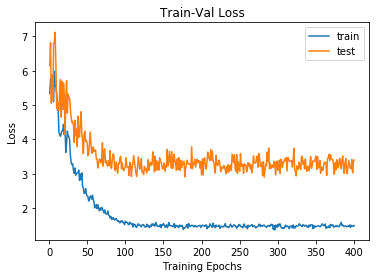

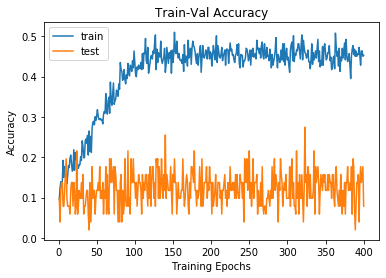

In [16]:
trainutils_leon.plot_loss(loss_hist, metric_hist)